# Information Retrieval I #
## Assignment 2: retrieval models [100 points + 10 bonus points] ##
**TA**: Christophe Van Gysel (cvangysel@uva.nl; C3.258B, Science Park 904)

**Secondary TAs**: Harrie Oosterhuis, Nikos Voskarides

In this assignment you will get familiar with basic information retrieval concepts. You will implement and evaluate different information retrieval ranking models and evaluate their performance.

We provide you with a VirtualBox image that comes pre-loaded with an index and a Python installation. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-two assignment**, the deadline is **23:59 - 25 January, 2017**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](https://piazza.com/class/ixoz63p156g1ts).

### Technicalities (must-read!) ###
This assignment comes pre-loaded on a VirtualBox running Ubuntu. We have configured the indexing software and Python environment such that it works out of the box. You are allowed to extract the files from the VirtualBox and set-up your own non-virtualized environment. However, in this case you are on your own w.r.t. software support.

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.
      
`Python + Jupyter`, `Indri`, `Gensim` and `Pyndri` come pre-installed (see `$HOME/.local`). TREC Eval can be found in `$HOME/Downloads/trec_eval.9.0`. The password of the `student` account on the VirtualBox is `datascience`.

In [14]:
# All Imports
import pyndri
import time
import pickle
from collections import Counter
import collections
import io
import logging
import sys
import numpy as np
import subprocess
import math
import scipy
import scipy.stats
import matplotlib.pyplot as plt

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [15]:
import logging
import sys

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example
Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [16]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [17]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [18]:
example_document = index.document(index.document_base())
print(example_document, 'lol')

('AP890425-0001', (1360, 192, 363, 0, 880, 0, 200, 0, 894, 412, 92160, 3, 192, 0, 363, 34, 1441, 0, 174134, 0, 200, 0, 894, 412, 2652, 0, 810, 107, 49, 4903, 420, 0, 1, 48, 35, 489, 0, 35, 687, 192, 243, 0, 249311, 1877, 0, 1651, 1174, 0, 2701, 117, 412, 0, 810, 391, 245233, 1225, 5838, 16, 0, 233156, 3496, 0, 393, 17, 0, 2435, 4819, 930, 0, 0, 200, 0, 894, 0, 22, 398, 145, 0, 3, 271, 115, 0, 1176, 2777, 292, 0, 725, 192, 0, 0, 50046, 0, 1901, 1130, 0, 192, 0, 408, 0, 243779, 0, 0, 553, 192, 0, 363, 0, 3747, 0, 0, 0, 0, 1176, 0, 1239, 0, 0, 1115, 17, 0, 0, 585, 192, 1963, 0, 0, 412, 54356, 0, 773, 0, 0, 0, 192, 0, 0, 1130, 0, 363, 0, 545, 192, 0, 1174, 1901, 1130, 0, 4, 398, 145, 39, 0, 577, 0, 355, 0, 491, 0, 6025, 0, 0, 193156, 88, 34, 437, 0, 0, 1852, 0, 828, 0, 1588, 0, 0, 0, 2615, 0, 0, 107, 49, 420, 0, 0, 190, 7, 714, 2701, 0, 237, 192, 157, 0, 412, 34, 437, 0, 0, 200, 6025, 26, 0, 0, 0, 0, 363, 0, 22, 398, 145, 0, 200, 638, 126222, 6018, 0, 880, 0, 0, 161, 0, 0, 319, 894, 2701, 

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [19]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]


Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [20]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [21]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [22]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [23]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

### Task 1: Implement and compare lexical IR methods [45 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html). **[5 points]**
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.2, ..., 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, ..., 2000]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.2, ..., 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[10 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

In the below cell all methods that are necessary for task 1 are created.

In [24]:
##########################################################################################################################
# Methods Task 1
##########################################################################################################################

def scoring(termPos, docFreq, termFreq, colFreq, querFreq, docLen, colLen, querLen, avgDocLen, docWords, colWords, docs, queries, invIndex, model, kern, Z, parameter = 0.0):
    """
    Calculates the score for each document-query pair.
    Input:
    docFreq: frequency of documents a term occurs in. Dictionary {term: frequency}
    termFreq: frequency of terms in a document. Dictionary of dictionaries {DOCID, {term: frequency, term: frequency}}
    colFreq: frequency of terms in the collection. Dictionary {term: frequency}
    docLen: total number of words per document. Dictionary {DOCID: #words}
    colLen: total number of words in the collection. Integer
    avgDocLen: average number of words in a document. Float
    docWords: number of unique words per document. Dictionary {DOCID: #unique}
    colWords: number of unique words in the collection. Integer
    docs: total number of documents. Integer
    queries: parsed query file. Dictionary {QID : query}
    invIndex: Inverted index that maps the documents a term occurs in. Dictionary {term: [DOCID's]}
    model: The model to score with. 
        TF-IDF: tf-idf scoring model.
        BM25: BM 25 scoring model.
        JM:  language model with Jellinek-Mercer smoothing.
        D: language model with Dirichlet smoothing.
        AD: language model with absolute discounting.
    parameter: specify lambda for JM, mu for D and delta for AD.
    Output:
    score: score for each query-document pair. Dictionary of lists of tuples {Q_ID: [(score, Doc_ID), (score, Doc_ID)]}
    """
    
    # Create a dictionary with empty lists to store scores for each doc-query pair
    score = {}

    # Preprocess queries to a list of tokens without stopwords    
    queryTokens = {}
    for QID,query in queries.items():
        queryTokens[QID] = preprocess_query(query)
    
    # "Switch" statement for different models
    if model == "TF-IDF":
        for QID in queries:
            score[QID] = []
        avgDoc = 0.0
        for QID, query in queryTokens.items():
            documents = set()
            for term in query:
                documents.update(invIndex[term])
            avgDoc += len(documents)
            for ID in documents:
                length = docLen[ID]
                relevance = 0.0
                for term in query:
                    if term in termFreq[ID]:
                        df = docFreq[term]
                        frequency = termFreq[ID][term]
                        relevance += tf_idf(df,frequency,docs)
                score[QID].append((relevance, ID))
        print(avgDoc/150.0)
    elif model == "BM25":
        for QID in queries:
            score[QID] = []

        for QID, query in queryTokens.items():
            documents = set()
            for term in query:
                documents.update(invIndex[term])
            for ID in documents:
                length = docLen[ID]
                score[QID].append((bm25_relevance(docFreq,termFreq[ID],length,avgDocLen,query,docs),ID))
    elif model == "JM":
        lamb = parameter

        for QID in queries:
            score[QID] = []

        for QID, query in queryTokens.items():
            documents = set()
            for term in query:
                documents.update(invIndex[term])
            for ID in documents:
                length = docLen[ID]
                score[QID].append((jellinek_mercer_relevance(docFreq,termFreq[ID],colFreq, length, colLen,query,lamb),ID))
    elif model == "D":
        mu = parameter
        
        for QID in queries:
            score[QID] = []

        for QID, query in queryTokens.items():
            documents = set()
            for term in query:
                documents.update(invIndex[term])
            for ID in documents:
                length = docLen[ID]
                score[QID].append((dirichlet_relevance(termFreq[ID], colFreq, length, colLen, query, mu),ID))
    elif model == "AD":
        delta = parameter

        for QID in queries:
            score[QID] = []

        for QID, query in queryTokens.items():
            documents = set()
            for term in query:
                documents.update(invIndex[term])
            for ID in documents:
                length = docLen[ID]
                words = docWords[ID]
                score[QID].append((absolute_discounting_relevance(termFreq[ID],colFreq,colLen,length,words,query,delta),ID))
    elif model == "PLM":
        mu = parameter
        
        for QID in queries:
            score[QID] = []
            
        for QID, query in queryTokens.items():
            documents = set()
            for term in query:
                documents.update(invIndex[term])
            for ID in documents:
                length = docLen[ID]
                score[QID].append((plm_relevance_vec(termPos[ID],querFreq[QID],colFreq,querLen[QID],length,colLen,query,mu,kern,Z),ID))
#             en = time.time()
#             print(en - star)
    else:
        print("Invalid model")
    
    return score         
         
        
def plm_relevance(termPos,querFreq,colFreq,querLen,docLen,colLen,queryTokens,mu,kern,Z):
    """
    Calculates the score of a document-query pair using a positional language model with given kernel.
    Uses Dirichlet smoothing with given mu parameter.
    Sigma is 50.0 for all kernels
    """
    score = [0]*docLen
    
    for term in queryTokens:
        pWQ = querFreq[term]/querLen
        pWC = float(colFreq[term])/colLen
        if term in termPos:
            for i in range(docLen):
                cTI = 0.0
                for j in termPos[term]:
                    cTI += kern[i][j]
                pWDi = (cTI + mu * pWC)/(Z[i][docLen] + mu)
                score[i] += -pWQ * np.log2(pWQ/pWDi)

    return max(score)

def plm_relevance_vec(termPos,querFreq,colFreq,querLen,docLen,colLen,queryTokens,mu,kern,Z):
    """
    Calculates the score of a document-query pair using a positional language model with given kernel.
    Uses Dirichlet smoothing with given mu parameter.
    Sigma is 50.0 for all kernels.
    Vecorized implementation for speedup
    """
    score = np.zeros(docLen)
    
    for term in queryTokens:
        pWQ = querFreq[term]/querLen
        pWC = float(colFreq[term])/colLen
        cT = np.zeros(docLen)
        if term in termPos:
            for j in termPos[term]:
                cT += kern[0:docLen,j]
        pWDi = (cT + mu * pWC)/(Z[0:docLen,docLen] + mu)
        score[:] += -pWQ * np.log2(pWQ/pWDi)

    return max(score)


def query_stats(queries):
    queryTokens = {}
    for QID,query in queries.items():
        queryTokens[QID] = preprocess_query(query)
        
    querFreq = {}
    querLen = {}
    
    for QID,query in queryTokens.items():
        querFreq[QID] = {}
        querLen[QID] = len(query)
        for q in query:
            if q in querFreq:
                querFreq[QID][q] += 1.0
            else:
                querFreq[QID][q] = 1.0
                
    return querLen, querFreq
    
            
    
def kernel(kern,i,j,sigma):
    """
    Calculates a proximity based density function based on a given kernel, current position i, event position j and sigma.
    sigma should be given as a float.
    """
    
    # Kernel "switch" statement
    if kern == "Gaussian":
        return np.exp((-(i-j)**2) / (2*sigma**2))
    elif kern == "Triangle":
        if abs(i-j) <= sigma:
            return 1.0 - abs(i-j)/sigma
        else:
            return 0.0
    elif kern == "Cosine":
        if abs(i-j) <= sigma:
            return (1.0 + math.cos((abs(i-j)*math.pi)/sigma))/2.0
        else:
            return 0.0
    elif kern == "Circle":
        if abs(i-j) <= sigma:
            return 1.0 - (abs(i-j)/sigma)**2.0
        else:
            return 0.0
    elif kern == "Passage":
        if abs(i-j) <= sigma:
            return 1.0 
        else:
            return 0.0               
    

def tf_idf(df,tf,docs):
    """
    Calculates the tf-idf of a term given the document frequency, term frequency and number of documents in the collection
    """
    idf = float(docs)/df
    return np.log2(1.0 + tf) * np.log2(idf)


def tf_idf_relevance(tfIdf, queryTokens):
    """ 
    Calculates the score of a document-query pair given the tf-idf of terms in the document and the query string
    """
    relevance = 0.0
    
    # relevance = sum of tfidf for terms in query
    for term in queryTokens:
        if term in tfIdf:
            relevance += tfIdf[term]
        
    return relevance
    
    
def bm25_relevance(df,tf,docLen,avgDocLen,queryTokens,docs, k1 = 1.2, b = 0.75):
    """
    Calculates the relevance of a document for a query using the BM25 model
    """
    relevance = 0.0
    
    # Calculate BM25 relevance
    for term in queryTokens:
        if term in tf:
            relevance += (((k1 + 1.0)*tf[term])/(k1*((1-b) + b*(float(docLen)/avgDocLen)) + tf[term])) * np.log2(float(docs)/df[term])
        
    return relevance

def jellinek_mercer_relevance(df,tf,cf,docLen,colLen,queryTokens,lamb):
    """
    Calculates the relevance of a document for a query using a basic language model with jellinek mercer smoothing.
    """
    relevance = 0.0
    
    # Calculate likelihood for a query given a document, smoothing the word likelihoods with collection information
    for term in queryTokens:
        if term in tf:
             # Relevance is the log-likelihood, compute log here to avoid underflow
            relevance += np.log2((lamb * (float(tf[term])/docLen) + (1-lamb) * (float(cf[term])/colLen)))
        else:
            relevance += np.log2(((1-lamb) * (float(cf[term])/colLen)))
        
   
    return relevance


def plot_lm(scores,model):
    filenamesJM = ["scoreJM_u_0.1","scoreJM_u_0.2","scoreJM_u_0.3","scoreJM_u_0.4",
             "scoreJM_u_0.5","scoreJM_u_0.6","scoreJM_u_0.7","scoreJM_u_0.8","scoreJM_u_0.9"]
    filenamesD =["scoreD_u_500.0","scoreD_u_1000.0","scoreD_u_1500.0","scoreD_u_2000.0"]
    filenamesAD = ["scoreAD_u_0.1","scoreAD_u_0.2","scoreAD_u_0.3","scoreAD_u_0.4","scoreAD_u_0.5",
             "scoreAD_u_0.6","scoreAD_u_0.7","scoreAD_u_0.8","scoreAD_u_0.9"]
    JMNDCG = []
    DNDCG = []
    ADNDCG =[]
    for filename in filenamesJM:
        JMNDCG.append(scores[filename][model])
    for filename in filenamesD:
        DNDCG.append(scores[filename][model])
    for filename in filenamesAD:
        ADNDCG.append(scores[filename][model])
        
    x = np.arange(0.1,1.0,0.1)
    x2 = np.arange(500.0,2500.0,500.0)
    
    fig = plt.figure(1,figsize=(10,8))
    plt.suptitle(model)
    plt.subplot(311)
    plt.plot(x,JMNDCG)
    plt.xlabel("lambda parameter")
    plt.ylabel("Jellinek Mercer")
    plt.subplot(312)
    plt.plot(x,ADNDCG)
    plt.xlabel("delta parameter")
    plt.ylabel("Absolute discounting")
    plt.subplot(313)
    plt.plot(x2,DNDCG)
    plt.xlabel("mu parameter")
    plt.ylabel("Dirichlet")
    fig.savefig("lm_"+model+".png", bbox_inches='tight')
    plt.show()
    
def plot_plm(scores,model):
    filenames = ["triangle","cos","gauss","pass","circle"]
    score = {}
    for filename in filenames:
        score[filename] = []
        for parameter in np.arange(300.0,950.0,50.0):
            score[filename].append(scores["scorePLM_"+filename+"_val_vec_"+str(parameter)][model])
        
    x = np.arange(300.0,950.0,50.0)
    color = ['r','g','b','p','y']
    
    fig, ax = plt.subplots(figsize=(10,8))
    plt.title(model)
    for i,filename in enumerate(filenames):
        ax.plot(x,score[filename],color[i],label=filename)    
    legend = ax.legend(loc='upper right', shadow=True)
    fig.savefig("plm_"+model+".png", bbox_inches='tight')
    plt.show()
   
            

def absolute_discounting_relevance(tf,cf,colLen,docLen,docWords,queryTokens, delta):
    """
    Calculates the relevance of a document for a query using a basic language model with absolute discounting smoothing.
    """
    relevance = 0.0
    
    # Calculate likehood for a query given a document, smoothing the word likelihoods with collection information
    for term in queryTokens:
        if term in tf:
            # Relevance is the log-likelihood, compute here to avoid underflow
            relevance += np.log2((max(tf[term] - delta, 0)/float(docLen) + (delta * docWords / docLen) * (float(cf[term])/colLen)))
        else:
            relevance += np.log2(((delta * docWords / docLen) * (float(cf[term])/colLen)))
        
    # Relevance is the log-likelihood
    return relevance

def dirichlet_relevance(tf, cf, docLen, colLen, queryTokens, mu):
    """
    Calculates the relevance of a document for a query using a basic language model with absolute discounting smoothing.
    """
    relevance = 0.0
    
    # Calculate likehood for a query given a document, smoothing the word likelihoods with a dirichlet prior
    for term in queryTokens:
        if term in tf:
            relevance += np.log2(((float(docLen) / (docLen + mu)) * (tf[term]/float(docLen)) + (float(mu)/(mu+docLen)) * (float(cf[term])/colLen)))
        else:
            relevance += np.log2(((float(mu)/(mu+docLen)) * (float(cf[term])/colLen)))
    
    # Relevance is the log-likelihood
    return relevance
    

def preprocess_query(query):
    """
    Preprocess a query string to a list of tokens without stopwords.
    """
    query = index.tokenize(query)
    queryTokens = [token2id.get(q,0) for q in query]
    queryTokens = [word_id for word_id in queryTokens if word_id > 0]
    return queryTokens


def calc_TF(queries):
    """
    This function takes all the queries as the input and returns term frequencies and number of unique words 
    in each document.
    Term frequency data structure is a dictionary of dictionary. Where, for each document id you get a dictionary which contains the
    term frequencies for the query vocabulary.
    """
    query = []
    token2id, id2token, id2df = index.get_dictionary()
    
    for query_id in queries:
        query_tokens = index.tokenize(queries[query_id])
        query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
        query.extend([word_id for word_id in query_id_tokens if word_id > 0])
    
    docs = []
    
    for docID in range(index.document_base(),index.maximum_document()):
        docs.append(index.document(docID))

    termFreq = {}
    uniqWords = {}
    invertedIndx = {}
    
    for q in query:
        invertedIndx[q] = []
    
    for docID in range(index.maximum_document()-1):
        tf_doc = Counter(docs[docID][1])
        tf_doc = dict(tf_doc)
        temp = {}
#         temp = {q:tf_doc[q] for q in query if q in tf_doc.keys()}
        for q in query:
            if q in tf_doc.keys():
                temp[q] = tf_doc[q]
                invertedIndx[q].append(docs[docID][0]) 
        termFreq[docs[docID][0]] = temp
        uniqWords[docs[docID][0]] = len(tf_doc.keys())-1
    return termFreq, uniqWords, invertedIndx

def avg_doc_length():
    """
    Calculates the average length of documents in the collection. 
    Also returns a dictionary of the number of words in each document.
    """
    docLength = {}
    docLengthsum = 0
    maxLength = 0
    for docID in range(index.document_base(),index.maximum_document()):
        length = index.document_length(docID)
        docLength[index.ext_document_id(docID)] = length
        docLengthsum += length
        if length > maxLength:
            maxLength = length
    return docLength, maxLength, docLengthsum/(index.maximum_document()-index.document_base())


def kernel_matrix(kern,maxDocLen):
    """
    Compute the kernel matrix given a kernel function and dimension
    """
    # dictionary for fastest lookup time
    kernMat = np.empty([maxDocLen,maxDocLen])
    for i in range(maxDocLen):
        for j in range (maxDocLen):
            kernMat[i][j] = kernel(kern,i,j,50.0)
    return kernMat


class TrecEvaluator:
    """
    Class for running trec evaluations from python using shell scripting.
    Credits and thanks to Jonas Kohler for providing the base for this class.
    """
    
    def __init__(self, validation_data, runfile_name="run"):
        self._runfile_name = runfile_name
        self._validation_data = validation_data
        
    def evaluate(self, data, full):
        # Create runfile and evaluate using TREC Eval
        with open(self._runfile_name, "w") as f:
            write_run(
                model_name=self._runfile_name,
                data=data,
                out_f=f,
                max_objects_per_query=1000)
        if full:
            return self._call_trec_eval_full()
        else:
            return self._call_trec_eval()
    
    def _call_trec_eval(self):
        # Trec eval for mean scores on the 4 scoring methods
        cmd = ['./run_trec_eval.sh', self._validation_data, self._runfile_name]
        p = subprocess.Popen(cmd, stdout=subprocess.PIPE)
        result = {}
        for line in p.stdout:
            frags = line.decode().strip().split()
            result[frags[0]] = float(frags[2])
        p.wait()
        return result
    
    def _call_trec_eval_full(self):
        # Trec eval for scores per query on 4 scoring methods
        cmd = ['./run_trec_eval.sh', self._validation_data, self._runfile_name]
        p = subprocess.Popen(cmd, stdout=subprocess.PIPE)
        result = {}
        QID = {}
        for line in p.stdout:
            frags = line.decode().strip().split()
            if str(frags[0]) in result:
                result[str(frags[0])].append(float(frags[2]))
                QID[str(frags[0])].append(str(frags[1]))
            else:
                result[str(frags[0])] = [float(frags[2])]
                QID[str(frags[0])] = [str(frags[1])]
        p.wait()
        return result,QID
        


##########################################################################################################################
# Computation
##########################################################################################################################


# TODO: Postional Language Models

# TODO: Hyperparameter setting on validation set

# Experiments and result collection using TREC eval 

# Paired student's t-test with Bonferonni correction on results

In this cell all the necessary statistics about documents are collected.

In [12]:
##########################################################################################################################
# Computation Task 1
##########################################################################################################################

# Pyndri document index
index = pyndri.Index('index/')

# Computing and storing all necessary statistics about documents, queries and the collection
start = time.time()
token2id, id2token, docFreq = index.get_dictionary() # index dictionaries and document frequency
colFreq = index.get_term_frequencies() # total number of term occurences in entire collection per term
docs = index.maximum_document() - index.document_base() # no of documents
colWords = index.unique_terms() # number of unique words in the collection
colLen = index.total_terms() # total number of words in the collection
with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics]) # query ID's paired with query in a dict
querLen, querFreq = query_stats(queries)
termFreq, docWords, invIndex = calc_TF(queries) # term frequency and number of unique words per document
docLen, maxDocLen, avgDocLen = avg_doc_length() # length of each document and average document length
valID = [103,111,114,120,123,135,143,144,151,155,158,165,167,170,173,180,182,192,53,57,69,74,78,86,89,90,92,93,94,95]
valQueries = {} # queries of the validation set, for faster validation testing
termPos = pickle.load(open("queryPosDoc.pkl", "rb"))
for key,query in queries.items():
    i = int(key)
    if i in valID:
        valQueries[key] = query
end = time.time()
print(end-start)

32.974273920059204


In [13]:
score = scoring(termPos, docFreq, termFreq, colFreq, querFreq, docLen, colLen, querLen, avgDocLen, docWords, colWords, docs, queries,invIndex, "TF-IDF",False, False, 0)

23790.206666666665


In [14]:
# Compute kernel matrices for all five kernels, to be used with PLM scoring and pickle them
start = time.time()
pickle.dump(kernel_matrix("Gaussian",maxDocLen), open("gaussKern.pkl", "wb"))
pickle.dump(kernel_matrix("Passage",maxDocLen), open("passKern.pkl", "wb"))
pickle.dump(kernel_matrix("Triangle",maxDocLen), open("trianKern.pkl", "wb"))
pickle.dump(kernel_matrix("Cosine",maxDocLen), open("cosKern.pkl", "wb"))
pickle.dump(kernel_matrix("Circle",maxDocLen), open("circKern.pkl", "wb"))
end = time.time()

print(end-start)

33.36307191848755


In this cell the scores are computed and stored.

In [86]:
for parameter in np.arange(0.1,1.0,0.1):
    start = time.time()
    score = scoring(termPos, docFreq, termFreq, colFreq, querFreq, docLen, colLen, querLen, avgDocLen, docWords, colWords, docs, valQueries,invIndex, "JM",False, False, parameter)
    end = time.time()
    print("Scoring Time JM: " + str(end-start))

    start = time.time()
    pickle.dump(score, open('scoreJM_u_' + str(parameter) + '.pkl', 'wb'))
    end = time.time()
    print("Pickle Time: " + str(end-start))
    
for parameter in np.arange(0.1,1.0,0.1):
    start = time.time()
    score = scoring(termPos,docFreq, termFreq, colFreq, querFreq, docLen, colLen, querLen, avgDocLen, docWords, colWords, docs, valQueries,invIndex, "AD", False, False, parameter)
    end = time.time()
    print("Scoring Time AD: " + str(end-start))

    start = time.time()
    pickle.dump(score, open('scoreAD_u_' + str(parameter) + '.pkl', 'wb'))
    end = time.time()
    print("Pickle Time: " + str(end-start))
    
for parameter in np.arange(500.0,2500.0,500.0):
    start = time.time()
    score = scoring(termPos,docFreq, termFreq, colFreq, querFreq, docLen, colLen, querLen, avgDocLen, docWords, colWords, docs, valQueries,invIndex, "D", False, False, parameter)
    end = time.time()
    print("Scoring Time D: " + str(end-start))

    start = time.time()
    pickle.dump(score, open('scoreD_u_' + str(parameter) + '.pkl', 'wb'))
    end = time.time()
    print("Pickle Time: " + str(end-start))
# gaussKern = False
# gaussZ = False

# kern = pickle.load(open("gaussKern.pkl", "rb"))
# Z = pickle.load(open("GaussianZ.pkl", "rb"))
# Z = Z * np.sqrt(2.0*np.pi*50**2)
# kern = pickle.load(open("passKern.pkl", "rb"))
# Z = pickle.load(open("PassageZ.pkl", "rb"))
# kern = pickle.load(open("trianKern.pkl", "rb"))
# Z = pickle.load(open("TriangleZ.pkl", "rb"))
# kern = pickle.load(open("cosKern.pkl", "rb"))
# Z = pickle.load(open("CosineZ.pkl", "rb"))
# kern = pickle.load(open("circKern.pkl", "rb"))
# Z = pickle.load(open("CircleZ.pkl", "rb"))
    
# for parameter in np.arange(300.0,950.0,50.0):
#     start = time.time()
#     score = scoring(termPos, docFreq, termFreq, colFreq, querFreq, docLen, colLen, querLen, avgDocLen, docWords, colWords, docs, valQueries,invIndex,"PLM", kern, Z, parameter)
#     end = time.time()
#     print("Scoring Time PLM: " + str(end-start))

#     start = time.time()
#     pickle.dump(score, open('scorePLM_gauss_val_vec_' + str(parameter) + '.pkl', 'wb'))
#     end = time.time()
#     print("Pickle Time: " + str(end-start))
    
# kern = pickle.load(open("passKern.pkl", "rb"))
# Z = pickle.load(open("PassageZ.pkl", "rb"))
    
# for parameter in np.arange(300.0,950.0,50.0):
#     start = time.time()
#     score = scoring(termPos, docFreq, termFreq, colFreq, querFreq, docLen, colLen, querLen, avgDocLen, docWords, colWords, docs, valQueries,invIndex,"PLM", kern, Z, parameter)
#     end = time.time()
#     print("Scoring Time PLM: " + str(end-start))

#     start = time.time()
#     pickle.dump(score, open('scorePLM_pass_val_vec_' + str(parameter) + '.pkl', 'wb'))
#     end = time.time()
#     print("Pickle Time: " + str(end-start))
    
# kern = pickle.load(open("trianKern.pkl", "rb"))
# Z = pickle.load(open("TriangleZ.pkl", "rb"))
    
# for parameter in np.arange(300.0,950.0,50.0):
#     start = time.time()
#     score = scoring(termPos, docFreq, termFreq, colFreq, querFreq, docLen, colLen, querLen, avgDocLen, docWords, colWords, docs, valQueries,invIndex,"PLM", kern, Z, parameter)
#     end = time.time()
#     print("Scoring Time PLM: " + str(end-start))

#     start = time.time()
#     pickle.dump(score, open('scorePLM_triangle_val_vec_' + str(parameter) + '.pkl', 'wb'))
#     end = time.time()
#     print("Pickle Time: " + str(end-start))
    
# kern = pickle.load(open("cosKern.pkl", "rb"))
# Z = pickle.load(open("CosineZ.pkl", "rb"))
    
# for parameter in np.arange(300.0,950.0,50.0):
#     start = time.time()
#     score = scoring(termPos, docFreq, termFreq, colFreq, querFreq, docLen, colLen, querLen, avgDocLen, docWords, colWords, docs, valQueries,invIndex,"PLM", kern, Z, parameter)
#     end = time.time()
#     print("Scoring Time PLM: " + str(end-start))

#     start = time.time()
#     pickle.dump(score, open('scorePLM_cos_val_vec_' + str(parameter) + '.pkl', 'wb'))
#     end = time.time()
#     print("Pickle Time: " + str(end-start))
    
# kern = pickle.load(open("circKern.pkl", "rb"))
# Z = pickle.load(open("CircleZ.pkl", "rb"))
    
# for parameter in np.arange(300.0,950.0,50.0):
#     start = time.time()
#     score = scoring(termPos, docFreq, termFreq, colFreq, querFreq, docLen, colLen, querLen, avgDocLen, docWords, colWords, docs, valQueries,invIndex,"PLM", kern, Z, parameter)
#     end = time.time()
#     print("Scoring Time PLM: " + str(end-start))

#     start = time.time()
#     pickle.dump(score, open('scorePLM_circle_val_vec_' + str(parameter) + '.pkl', 'wb'))
#     end = time.time()
#     print("Pickle Time: " + str(end-start))


Scoring Time JM: 6.621187210083008
Pickle Time: 2.6332931518554688
Scoring Time JM: 6.423957347869873
Pickle Time: 2.5779733657836914
Scoring Time JM: 6.5830206871032715
Pickle Time: 2.6302671432495117
Scoring Time JM: 6.350944995880127
Pickle Time: 2.5674870014190674
Scoring Time JM: 6.281620979309082
Pickle Time: 2.4896624088287354
Scoring Time JM: 6.485511541366577
Pickle Time: 2.5868632793426514
Scoring Time JM: 6.314316034317017
Pickle Time: 2.689418315887451
Scoring Time JM: 6.457895517349243
Pickle Time: 2.5621697902679443
Scoring Time JM: 6.383546829223633
Pickle Time: 2.4414303302764893
Scoring Time AD: 7.274507522583008
Pickle Time: 2.646294116973877
Scoring Time AD: 7.478564977645874
Pickle Time: 2.5453310012817383
Scoring Time AD: 7.595813989639282
Pickle Time: 2.4531495571136475
Scoring Time AD: 7.357303857803345
Pickle Time: 2.435089588165283
Scoring Time AD: 7.337769985198975
Pickle Time: 2.572361707687378
Scoring Time AD: 7.345983266830444
Pickle Time: 2.524109125137329

In [ ]:
## Test Run

In [72]:

    

print(Z[200][400])
print()

57.0796326795



In this cell TREC_EVAL validation is done for the language models and TREC_EVAl test for the best language models and other models. These results are stored

In [77]:
# evaluation = {}
# filenames = ["scoreJM_u_0.1","scoreJM_u_0.2","scoreJM_u_0.3","scoreJM_u_0.4",
#              "scoreJM_u_0.5","scoreJM_u_0.6","scoreJM_u_0.7","scoreJM_u_0.8","scoreJM_u_0.9",
#              "scoreD_u_500.0","scoreD_u_1000.0","scoreD_u_1500.0","scoreD_u_2000.0",
#              "scoreAD_u_0.1","scoreAD_u_0.2","scoreAD_u_0.3","scoreAD_u_0.4","scoreAD_u_0.5",
#              "scoreAD_u_0.6","scoreAD_u_0.7","scoreAD_u_0.8","scoreAD_u_0.9"]
filenames = ["triangle","cos","gauss","pass","circle"]
# for filename in filenames:
#     for parameter in np.arange(300.0,950.0,50.0):
        
#         runfile = "scorePLM_"+filename+"_val_vec_"+str(parameter)
#         data = pickle.load(open(runfile + ".pkl","rb"))
#         print(data['123'][1])
#         trec_eval = TrecEvaluator(validation_data="ap_88_89/qrel_validation",runfile_name=filename +"_run")
#         evaluation[runfile] = trec_eval.evaluate(data=data,full=False)
    
# print(evaluation)
# pickle.dump(evaluation,open("model_validation_plm.pkl", "wb"))

#Determine best parameter value for the language models


# wins_jm = {}
# avg_jm = {}
# avg_ad = {}
# avg_d = {}
# wins_ad = {}
# wins_d = {}
# for i in np.arange(0.1,1,0.1):
#     wins_jm[str(i)] = 0
#     wins_ad[str(i)] = 0
#     avg_jm[str(i)] = 0.0
#     avg_ad[str(i)] = 0.0
#     for j in np.arange(0.1,1,0.1):
#         for key, score in evaluation['scoreJM_u_'+str(i)].items():
#             avg_jm[str(i)] += score/9.0
#             if evaluation['scoreJM_u_'+str(j)][key] < score:
#                 wins_jm[str(i)] += 1
#         for key, score in evaluation['scoreAD_u_'+str(i)].items():
#             avg_ad[str(i)] += score/9.0
#             if evaluation['scoreAD_u_'+str(j)][key] < score:
#                 wins_ad[str(i)] += 1
                
# # for filename in filenames:
# for i in np.arange(500.0,2500.0,500.0):
#     wins_d[str(i)] = 0
#     avg_d[str(i)] = 0.0
#     for j in np.arange(500.0,2500.0,500.0):
# #                 runfilei = "scorePLM_"+filename+"_val_vec_"+str(i)
# #                 runfilej = "scorePLM_"+filename2+"_val_vec_"+str(j)
#         for key, score in evaluation["scoreD_u_"+str(i)].items():
#             avg_d[str(i)] += score/4.0
#             if evaluation["scoreD_u_"+str(j)][key] < score:
#                 wins_d[str(i)] += 1

winsPlm = {}


for filename in filenames:
    winsPlm[filename] = []
    for i in np.arange(300.0,950.0,50.0):
        wins = 0
        for j in np.arange(300.0,950.0,50.0):
            runfilei = "scorePLM_"+filename+"_val_vec_"+str(i)
            runfilej = "scorePLM_"+filename+"_val_vec_"+str(j)
            for key, score in evaluation[runfilei].items():
                if evaluation[runfilej][key] < score:
                    wins += 1
        winsPlm[filename].append((i,wins))
                    
print(winsPlm)
    
                        
# avg_score = {}
# avg_score_param = {}
# for filename in filenames:
#     avg_score[filename] = {}
#     count = 0.0
#     for i in np.arange(300.0,950.0,50.0):
#         if i not in avg_score_param:
#             avg_score_param[i] = {}
#         runfilei = "scorePLM_"+filename+"_val_vec_"+str(i)
#         for key, score in evaluation[runfilei].items():
#             if key in avg_score_param[i]:
#                 avg_score_param[i][key] += score/5.0
#             else:
#                 avg_score_param[i][key] = score/5.0
#             if key in avg_score[filename]:
#                 avg_score[filename][key] += score
#                 count += 1/4
#             else:
#                 avg_score[filename][key] = score
#                 count += 1/4
#     for key in avg_score[filename]:
#         avg_score[filename][key] /= count
                
            
        
    
                
# We select the best parameter value based on the number of 'wins' it has. The score averages are for validation, they check out.
# print(wins_jm)
# print(avg_jm)
# print(wins_ad)
# print(avg_ad)
# print(wins_d)
# print(avg_d)
# print(avg_score)
# print(avg_score_param)

# # Filenames for testing, parameter values are determined based on above evaluation of parameter settings.
# testFiles = ["scoreTfIdf","scoreBM25","scoreJM0.2","scoreAD0.7","scoreD1500.0"]

# # Create the runfile for the test-scores and compute and store the results per query per method on the 4 measures.
# testResults = {}
# for filename in testFiles:
#     data = pickle.load(open(filename + ".pkl","rb"))
#     trec_eval = TrecEvaluator(validation_data="ap_88_89/qrel_test",runfile_name=filename +"_run_test_full")
#     testResults[filename] = trec_eval.evaluate(data=data,full=True)
    
# print(testResults)
# pickle.dump(testResults,open("model_test3.pkl", "wb"))
        
    
        

{'circle': [(300.0, 15), (350.0, 15), (400.0, 18), (450.0, 18), (500.0, 8), (550.0, 12), (600.0, 18), (650.0, 18), (700.0, 28), (750.0, 22), (800.0, 27), (850.0, 41), (900.0, 30)], 'cos': [(300.0, 26), (350.0, 22), (400.0, 16), (450.0, 8), (500.0, 16), (550.0, 17), (600.0, 9), (650.0, 20), (700.0, 25), (750.0, 33), (800.0, 34), (850.0, 23), (900.0, 25)], 'gauss': [(300.0, 5), (350.0, 14), (400.0, 20), (450.0, 21), (500.0, 30), (550.0, 29), (600.0, 25), (650.0, 14), (700.0, 10), (750.0, 25), (800.0, 26), (850.0, 22), (900.0, 25)], 'pass': [(300.0, 8), (350.0, 13), (400.0, 20), (450.0, 23), (500.0, 31), (550.0, 37), (600.0, 34), (650.0, 12), (700.0, 13), (750.0, 17), (800.0, 28), (850.0, 15), (900.0, 14)], 'triangle': [(300.0, 4), (350.0, 8), (400.0, 10), (450.0, 22), (500.0, 24), (550.0, 24), (600.0, 34), (650.0, 30), (700.0, 30), (750.0, 32), (800.0, 25), (850.0, 17), (900.0, 14)]}


In [79]:
for key, value in wins_d.items():
    print("Wins of "+str(key)+": "+str(value))
for key, value in avg_d.items():
    print("Average of "+str(key)+": "+str(value))
    
#Gauss: 500 - 30
#Pass: 550 - 37
#Triangle: 600 - 34
#Circle: 850- 41
#cos: 800 - 34
#jm: 0.2
#ad: 0.7
#d: 1500

Wins of cos650.0: 96
Wins of cos600.0: 79
Wins of triangle800.0: 147
Wins of triangle600.0: 166
Wins of cos700.0: 101
Wins of pass700.0: 130
Wins of pass450.0: 141
Wins of circle700.0: 101
Wins of pass800.0: 146
Wins of pass550.0: 176
Wins of gauss700.0: 144
Wins of cos900.0: 119
Wins of pass350.0: 122
Wins of triangle450.0: 123
Wins of circle650.0: 88
Wins of gauss650.0: 149
Wins of triangle700.0: 161
Wins of gauss400.0: 163
Wins of cos850.0: 112
Wins of circle600.0: 84
Wins of cos450.0: 62
Wins of triangle750.0: 164
Wins of triangle300.0: 81
Wins of triangle900.0: 124
Wins of pass650.0: 129
Wins of triangle850.0: 130
Wins of circle400.0: 84
Wins of circle800.0: 104
Wins of gauss750.0: 161
Wins of gauss500.0: 175
Wins of gauss800.0: 160
Wins of gauss600.0: 163
Wins of circle750.0: 95
Wins of cos750.0: 127
Wins of gauss550.0: 166
Wins of cos500.0: 70
Wins of pass400.0: 133
Wins of pass750.0: 134
Wins of gauss900.0: 163
Wins of triangle500.0: 141
Wins of cos550.0: 77
Wins of circle350.0

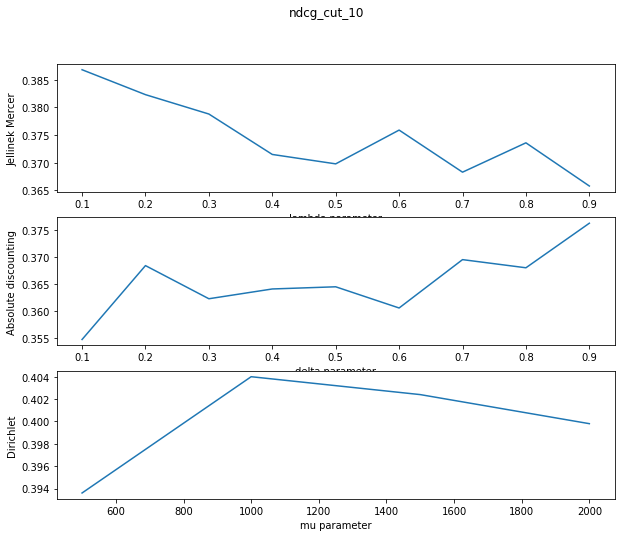

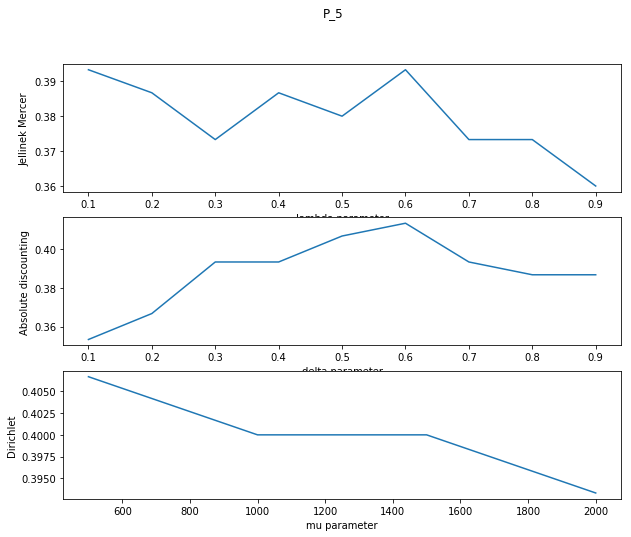

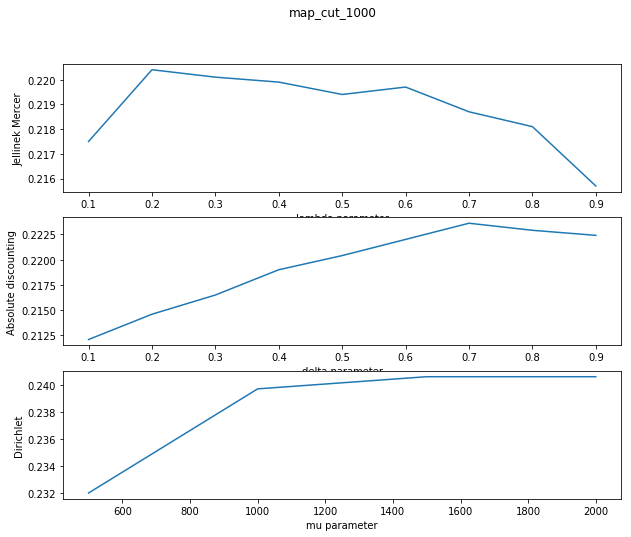

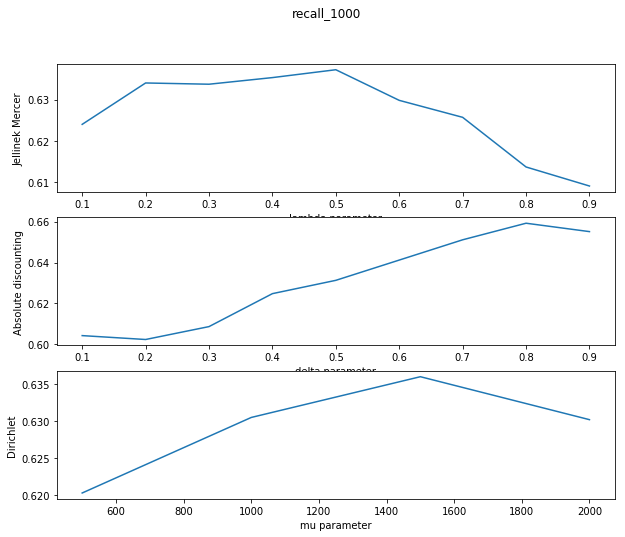

In [56]:
methods = ['ndcg_cut_10','P_5','map_cut_1000','recall_1000']
for method in methods:
    plot_lm(evaluation,method)

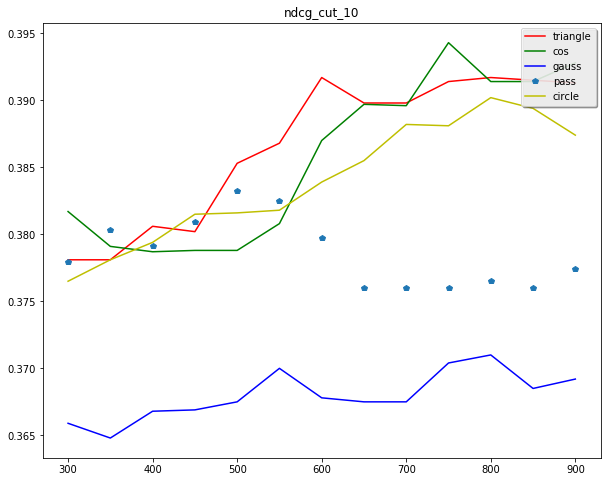

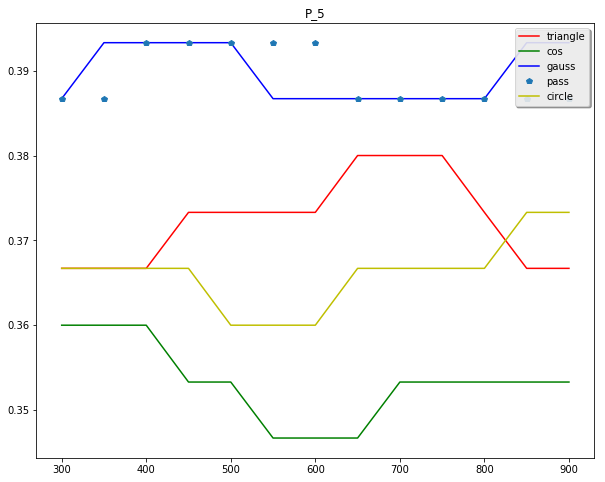

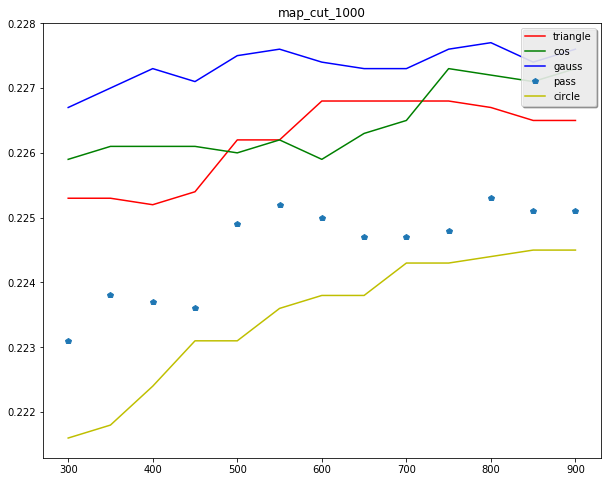

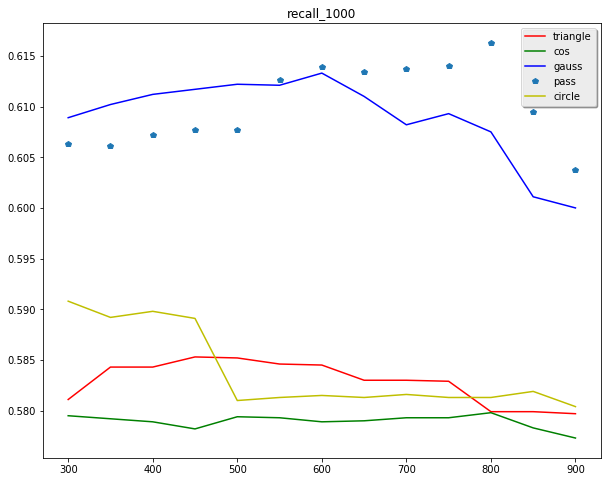

In [26]:
methods = ['ndcg_cut_10','P_5','map_cut_1000','recall_1000']
ev = pickle.load(open("model_validation_plm.pkl","rb"))
for method in methods:
    plot_plm(ev,method)


In [55]:
n = []
q = []
i = []
for ID, query in queries.items():
    m = 0
    for token in preprocess_query(query):
        if docFreq[token] > m:
            m = docFreq[token]
    if m < 1000:
        n.append(docFreq[token])
        q.append(query)
        i.append(ID)
        
print(8000-sum(n))

            
print(n)
print(q)
print(i)
print(t)
        

6055
[468, 157, 95, 161, 133, 253, 551, 127]
['Leveraged Buyouts', 'MCI', 'Surrogate Motherhood', 'Automation', 'Poaching', 'Greenpeace', 'Beachfront Erosion', 'Legality of Medically Assisted Suicides']
['53', '57', '70', '75', '77', '78', '188', '199']
198109


In [80]:
# Test run
# parameter settings:
#Gauss: 500 - 30
#Pass: 550 - 37
#Triangle: 600 - 34
#Circle: 850- 41
#cos: 800 - 34
#jm: 0.2
#ad: 0.7
#d: 1500
def run( model, tag, parameter=0, kern = False, ktag = '', Z = False):
    start = time.time()
    score = scoring(termPos, docFreq, termFreq, colFreq, querFreq, docLen, colLen, querLen, avgDocLen, docWords, colWords, docs, queries,invIndex, model, kern, Z, parameter)
    end = time.time()
    print("Scoring Time "+ model +": " + str(end-start))

    start = time.time()
    pickle.dump(score, open("Score_"+model+"_"+ktag+"_"+str(parameter) +"_"+tag+'.pkl', 'wb'))
    end = time.time()
    print("Pickle Time: " + str(end-start))

tag = "final_test"
run("AD",tag,0.7)
run("D",tag,1500.0)
run("JM",tag,0.2)
run("TF-IDF",tag)
run("BM25",tag)
kern = pickle.load(open("gaussKern.pkl", "rb"))
Z = pickle.load(open("GaussianZ.pkl", "rb"))
Z = Z * np.sqrt(2.0*np.pi*50**2)
run("PLM",tag,500.0,kern,"gauss",Z)
kern = pickle.load(open("passKern.pkl", "rb"))
Z = pickle.load(open("PassageZ.pkl", "rb"))
run("PLM",tag,550.0,kern,"pass",Z)
kern = pickle.load(open("trianKern.pkl", "rb"))
Z = pickle.load(open("TriangleZ.pkl", "rb"))
run("PLM",tag,600.0,kern,"trian",Z)
kern = pickle.load(open("cosKern.pkl", "rb"))
Z = pickle.load(open("CosineZ.pkl", "rb"))
run("PLM",tag,800.0,kern,"cos",Z)
kern = pickle.load(open("circKern.pkl", "rb"))
Z = pickle.load(open("CircleZ.pkl", "rb"))
run("PLM",tag,850.0,kern,"circ",Z)


/home/student/.local/lib/python3.5/site-packages/ipykernel/__main__.py:345: RuntimeWarning: divide by zero encountered in log2


Scoring Time AD: 37.06530261039734
Pickle Time: 29.46295976638794
Scoring Time D: 34.811877965927124
Pickle Time: 16.171809673309326
Scoring Time JM: 30.976361513137817
Pickle Time: 12.969752550125122
Scoring Time TF-IDF: 17.143826961517334
Pickle Time: 13.091753959655762
Scoring Time BM25: 16.633543491363525
Pickle Time: 13.197264909744263
Scoring Time PLM: 647.2102403640747
Pickle Time: 34.16385746002197
Scoring Time PLM: 672.4519212245941
Pickle Time: 19.883630514144897
Scoring Time PLM: 635.6687512397766
Pickle Time: 13.69995927810669
Scoring Time PLM: 639.1314821243286
Pickle Time: 14.995975494384766
Scoring Time PLM: 640.3904507160187
Pickle Time: 14.912850618362427


In [27]:
# score all test models
def run_trec(runfile, full):
        data = pickle.load(open(runfile + ".pkl","rb"))

        trec_eval = TrecEvaluator(validation_data="ap_88_89/qrel_test",runfile_name=runfile +"_run")
        return trec_eval.evaluate(data=data,full=full)
files = ["Score_PLM_gauss_500.0_final_test","Score_PLM_circ_850.0_final_test","Score_PLM_trian_600.0_final_test",
         "Score_PLM_cos_800.0_final_test","Score_PLM_pass_550.0_final_test","Score_D__1500.0_final_test",
         "Score_AD__0.7_final_test","Score_JM__0.2_final_test","Score_TF-IDF__0_final_test","Score_BM25__0_final_test"]

testResults = {}
testQID = {}
for file in files:
    testResults[file], testQID[file]  = run_trec(file,True)


In this cell multiple t-tests are run to compare all the models. Sidak correction is applied to the p-values.

In [37]:
# testRel = {}
# for model,values in testResults.items():
#     testRel[model] = []
#     for key, score in values.items():
#         testRel[model].append(score)
        
# Tests
comparison = {}
models = []
mean = {}
winCount = {}
noComp = 0
for model, scores in testResults.items():
    comparison[model] = {}
    models.append(model)
    mean[model] = {}
    for test, score in scores.items():
        mean[model][test] = sum(score)/float(len(score))
        comparison[model][test] = {}
        for model2, scores2 in testResults.items():
            if model2 not in models:
                    comparison[model][test][model2] = [0,0,0]
                    comparison[model][test][model2][0], comparison[model][test][model2][1] = scipy.stats.ttest_rel(score,scores2[test])
                    noComp += 1

# Multiple comparison correction using SIDAK, base p value for H0 rejection is 0.05
# SidakAlpha = 1.0 - (1.0 - 0.05)**(1.0/(noComp))
P = []
for model, comp in comparison.items():
    for test, scores in comp.items():
        for model2, score in scores.items():
            P.append(score[1])
            
P.sort()
cutOff = 0.0
for i, p in enumerate(P):
    if p > (0.05/(noComp - i)):
        cutOff = p
        break
        
count = 0
for model, comp in comparison.items():
    if model not in winCount:
        winCount[model] = {}
    for test, scores in comp.items():
        if test not in winCount[model]:
            winCount[model][test] = 0
        for model2, score in scores.items():
            if model2 not in winCount:
                winCount[model2] = {}
                winCount[model2][test] = 0
            elif test not in winCount[model2]:
                winCount[model2][test] = 0
            comparison[model][test][model2][2] = score[1] < cutOff
            if score[1] < cutOff:
                if score[0] > 0:
                    count += 1
                    winCount[model][test] += 1
                else:
                    count += 1
                    winCount[model2][test] += 1
                print(str(model) + " and " + str(model2) + " differ significantly for test " + str(test) +", with p=" + str(score[1]) + " and T=" + str(score[0]))    
            else:
                print(str(model) + " and " + str(model2) + " do not differ significantly for test " + str(test))
            
print(count)    
print(cutOff)
print(mean)
print(winCount)

        

        


    
        
        

        

        


Score_PLM_gauss_500.0_final_test and Score_AD__0.7_final_test differ significantly for test map_cut_1000, with p=9.5883725322e-05 and T=-4.03661368422
Score_PLM_gauss_500.0_final_test and Score_PLM_trian_600.0_final_test differ significantly for test map_cut_1000, with p=7.7503132183e-08 and T=5.72590538289
Score_PLM_gauss_500.0_final_test and Score_JM__0.2_final_test do not differ significantly for test map_cut_1000
Score_PLM_gauss_500.0_final_test and Score_PLM_cos_800.0_final_test differ significantly for test map_cut_1000, with p=4.34835711222e-08 and T=5.85016928292
Score_PLM_gauss_500.0_final_test and Score_PLM_pass_550.0_final_test do not differ significantly for test map_cut_1000
Score_PLM_gauss_500.0_final_test and Score_D__1500.0_final_test differ significantly for test map_cut_1000, with p=7.78004726175e-09 and T=-6.21267795236
Score_PLM_gauss_500.0_final_test and Score_TF-IDF__0_final_test differ significantly for test map_cut_1000, with p=0.000335293645299 and T=-3.6926991

In [ ]:
winCount = {}
for model, comp in comparison.items():
    winCount

In [75]:
"""
Query comparison stuff.
"""

def plot_queries(results,query,method):

    color = ['r','g','b','p','y','r','g','b','p','y']
    
    fig, ax = plt.subplots(figsize=(10,8))
    plt.title(method)
    i = 0
    for model, scores in results.items():
#         print(query[model][method][0:-2])
#         print(scores[method])
        q = []
        s = []
        for j, ID in enumerate(query[model][method][0:-2]):
#             if int(ID)%10 == 0:
            q.append(ID)
            s.append(scores[method][j])
        m = sorted(range(len(s)), key=lambda i: s[i])[-1:]
        l = sorted(range(len(s)), key=lambda i: s[i])[0:1]
#         x = m+l
        q = [q[j] for j in m]
        s = [s[j] for j in m]
        print(model)
        for QID, qu in queries.items():
            if QID in q:
                print(qu)
                tokens = preprocess_query(qu)
                for t in tokens:
                    print(docFreq[t])
                    #print(colFreq[t])
        
        ax.scatter(q,s,label=model)
        i += 1
    legend = ax.legend(loc='upper right', shadow=True)
    fig.savefig("queries_"+model+".png", bbox_inches='tight')
    plt.show()
    
def query_length(results,query,method):
    avgLen
        for model, scores in results.items():
            avgLen[model] = {}
            for j, ID in enumerate(query[model][method][0:-2]):
                length = len(preprocess_query(queries[ID]))
                if length in avgLen[model]:
                    avgLen[model][length] +=
                
            
query_length(testResults,testQID,method)
    
# print(testResults)
# print(testQID)
    
# methods = ['ndcg_cut_10','P_5','map_cut_1000','recall_1000']
# methods = ["map_cut_1000"]
# for method in methods:
#     plot_queries(testResults,testQID,method)

4
Controlling the Transfer of High Technology
7
Design of the "Star Wars" Anti-missile Defense System
9
Laser Research Applicable to the U.S.'s Strategic Defense Initiative
3
Catastrophic Health Insurance
2
"Black Monday"
5
U.S. Control of Insider Trading
4
Japanese Regulation of Insider Trading
3
Japanese Protectionist Measures
3
Find Innovative Companies
5
Black Resistance Against the South African Government
2
Funding Biotechnology
4
New Space Satellite Applications
4
Impact of the 1986 Immigration Law
3
Generic Drug Substitutions
6
Capacity of the U.S. Cellular Telephone Network
2
International Terrorists
3
Actions Against International Terrorists
2
Death from Cancer
6
RDT&E of New Cancer Fighting Drugs
4
Alternatives to Traditional Cancer Therapies
4
Anti-smoking Actions by Government
4
Medical Ethics and Modern Technology
9
U.S.-U.S.S.R. Arms Control Agreements
3
Privatization of State Assets
4
Soviet Spying on the U.S.
6
Jewish Emigration and U.S.-USSR Relations
5
McDonnell Doug

['Score_PLM_gauss_500.0_final_test', 'Score_PLM_trian_600.0_final_test', 'Score_JM__0.2_final_test', 'Score_PLM_cos_800.0_final_test', 'Score_PLM_pass_550.0_final_test', 'Score_D__1500.0_final_test', 'Score_TF-IDF__0_final_test', 'Score_BM25__0_final_test', 'Score_AD__0.7_final_test', 'Score_PLM_circ_850.0_final_test']
[0.19101239669421483, 0.1766760330578512, 0.19419752066115697, 0.17507107438016528, 0.18831074380165297, 0.2128710743801653, 0.21551735537190078, 0.21770743801652886, 0.20539586776859506, 0.1794851239669422]
['map_cut_1000', 'ndcg_cut_10', 'recall_1000', 'P_5']


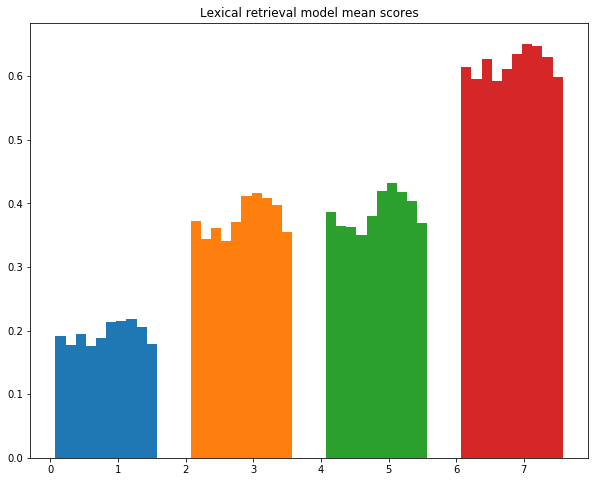

['map_cut_1000', 'ndcg_cut_10', 'recall_1000', 'P_5']


In [51]:
def plot_test_mean(means):
    fig, ax = plt.subplots(figsize=(10,8))
    plt.title("Lexical retrieval model mean scores")
    i = 0
    methods = []
    models = []
    maps = []
    ndcg = []
    prec = []
    rec = []
    
    for model, scores in means.items():
        models.append(model)
        for method, score in scores.items():
            if method not in methods:
                methods.append(method)
            if method == "map_cut_1000":
                maps.append(score)
            elif method == "ndcg_cut_10":
                ndcg.append(score)
            elif method == "recall_1000":
                rec.append(score)
            else:
                prec.append(score)
                
    print(models)
    print(maps)
    print(methods)
    w = []
    ind2 = [2.0]*10
    ind3 = [4.0]*10
    ind4 = [6.0]*10
    for i in range(10):
        w.append(0.15*(i+1))
    plt.bar(w,maps,width=0.15)
    plt.bar([x + y for x, y in zip(w, ind2)],ndcg,0.15)
    plt.bar([x + y for x, y in zip(w, ind3)],prec,0.15)
    plt.bar([x + y for x, y in zip(w, ind4)],rec,0.15)
    plt.show()
    print(methods)
    
plot_test_mean(mean)
            
            
        
    


### Task 2: Latent Semantic Models (LSMs) [25 points + 10 bonus points] ###

In this task you will experiment with applying a distributional semantics methods ([word2vec](http://arxiv.org/abs/1411.2738)  **[5 points]**, [LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]**, [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]** and [doc2vec](https://cs.stanford.edu/~quocle/paragraph_vector.pdf) **[5 points]**) for retrieval.

You do not need to implement word2vec, LSI, LDA and doc2vec on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html) (pre-loaded on the VirtualBox). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. For example, in the case of word2vec, you only have vectors for individual words and not for documents or phrases. Try one of the following methods for producing these representations:
   * Average or sum the word vectors.
   * Cluster words in the document using [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and use the centroid of the most important cluster. Experiment with different values of K for k-means.
   * Using the [bag-of-word-embeddings representation](https://ciir-publications.cs.umass.edu/pub/web/getpdf.php?id=1248). **[10 bonus points]**
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

### Task 3: Learning to rank (LTR) [10 points] ###

In this task you will get an introduction into learning to rank for information retrieval. You will experiment with a pointwise learning to rank method, logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

**NOTE**: you can only perform this task if you have completely finished Task 1 and Task 2.

In this experiment, you will use the retrieval methods you implemented in Task 1 and Task 2 as features for the learning to rank model. Train your LTR model using 10-fold cross validation on the test set. For every query, first create a document candidate set using the top-1000 documents using TF-IDF. Secondly, compute query-document values using the retrieval models above and use them as features. Note that the feature values of different retrieval methods are likely to be distributed differently.

Your approach will definitely not be as good as the state-of-the-art since you are taking a pointwise approach, but we do not ask you to try pair- or listwise methods because they will be the main topic of the next assignment.

In [1]:
from sklearn.linear_model import LogisticRegression

### Task 4: Write a report [20 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Do not send us the VirtualBox, but only the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file system structure as on the VirtualBox.
